# Load Library

In [1]:
import pandas as pd
import numpy as np
import pdcast as pdc
import seaborn as sns
from matplotlib import pyplot as plt
from skimpy import skim
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split, GridSearchCV      
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

#change to display all columns
pd.set_option('display.max_columns', None) 
sns.set_style("ticks")

# Load the data from the CSV files

## Read files from the working directory

In [2]:
airports = pd.read_csv("airports.csv", usecols=['iata', 'state','airport'])
planes = pd.read_csv("plane-data.csv", usecols=['tailnum', 'year'])
data_2006 = pd.read_csv("2006.csv")
data_2007 = pd.read_csv("2007.csv")

## Combine data_2006 and data_2007 into flight and clean the data set

In [3]:
flight = pd.concat([data_2006, data_2007]).reset_index(drop = True).drop_duplicates()
del(data_2006, data_2007)
flight = pdc.coerce_df(flight, pdc.infer_schema(flight))
flight.replace('', np.nan, inplace=True)

#filter out flights that were cancelled or diverted
flight = flight[(flight["Cancelled"] == 0) & (flight["Diverted"] == 0)]
flight = flight.drop(['TaxiIn', 'TaxiOut','CancellationCode','Diverted', 'Cancelled','UniqueCarrier'], axis=1)

## Create new columns to indicate if a plane experienced delays

In [4]:
flight['ADelay'] = flight.ArrDelay > 0
flight['DDelay'] = flight.DepDelay > 0

# Question 1: When is the best time of day, day of the week, and time of year to fly to minimize delays?

## Create a column to label flights according to the CRSDepTime in 2 hour intervals

In [5]:
flight['DepInterval']  = pd.cut(flight["CRSDepTime"], 
                                bins=[0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400], 
                                labels=["0000 ~ 0159 hrs", "0200 ~ 0359 hrs", "0400 ~ 0559 hrs", "0600 ~ 0759 hrs", 
                                        "0800 ~ 0959 hrs", "1000 ~ 1159 hrs", "1200 ~ 1359 hrs", "1400 ~ 1559 hrs", 
                                        "1600 ~ 1759 hrs", "1800 ~ 1959 hrs", "2000 ~ 2159 hrs", "2200 ~ 2359 hrs"], 
                                include_lowest=True)

## Select columns that is going to be used and put it in a new DataFrame

In [6]:
arrival_delay = flight[flight["ArrDelay"] > 0][["Year", "Month", "DayofMonth", "DayOfWeek", 
                                                  "CRSDepTime", "DepTime", "DepDelay", "ArrDelay", "DepInterval"]].copy()
arrival_delay

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,DepTime,DepDelay,ArrDelay,DepInterval
0,2006,1,11,3,745,743,-2,6,0600 ~ 0759 hrs
5,2006,1,11,3,630,627,-3,2,0600 ~ 0759 hrs
6,2006,1,11,3,820,825,5,20,0800 ~ 0959 hrs
7,2006,1,11,3,945,942,-3,7,0800 ~ 0959 hrs
14,2006,1,11,3,2045,2045,0,5,2000 ~ 2159 hrs
...,...,...,...,...,...,...,...,...,...
14595132,2007,12,15,6,1605,1558,-7,13,1600 ~ 1759 hrs
14595133,2007,12,15,6,1851,1902,11,5,1800 ~ 1959 hrs
14595134,2007,12,15,6,1025,1024,-1,15,1000 ~ 1159 hrs
14595135,2007,12,15,6,1315,1353,38,36,1200 ~ 1359 hrs


## Best time of day

,DepInterval,Percent
0,0000 ~ 0159 hrs,41.79
1,0200 ~ 0359 hrs,38.66
2,0400 ~ 0559 hrs,32.77
3,0600 ~ 0759 hrs,35.43
4,0800 ~ 0959 hrs,40.55
5,1000 ~ 1159 hrs,43.89
6,1200 ~ 1359 hrs,47.18
7,1400 ~ 1559 hrs,50.73
8,1600 ~ 1759 hrs,53.4
9,1800 ~ 1959 hrs,54.03


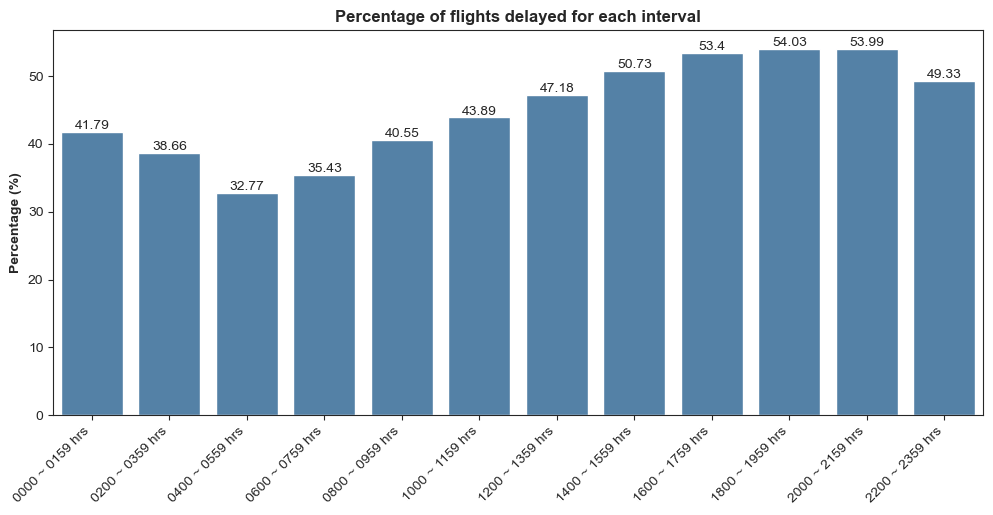

,DepInterval,ArrDelay
0,0000 ~ 0159 hrs,24.43
1,0200 ~ 0359 hrs,33.55
2,0400 ~ 0559 hrs,21.97
3,0600 ~ 0759 hrs,21.92
4,0800 ~ 0959 hrs,24.08
5,1000 ~ 1159 hrs,25.92
6,1200 ~ 1359 hrs,30.07
7,1400 ~ 1559 hrs,33.79
8,1600 ~ 1759 hrs,37.83
9,1800 ~ 1959 hrs,39.49


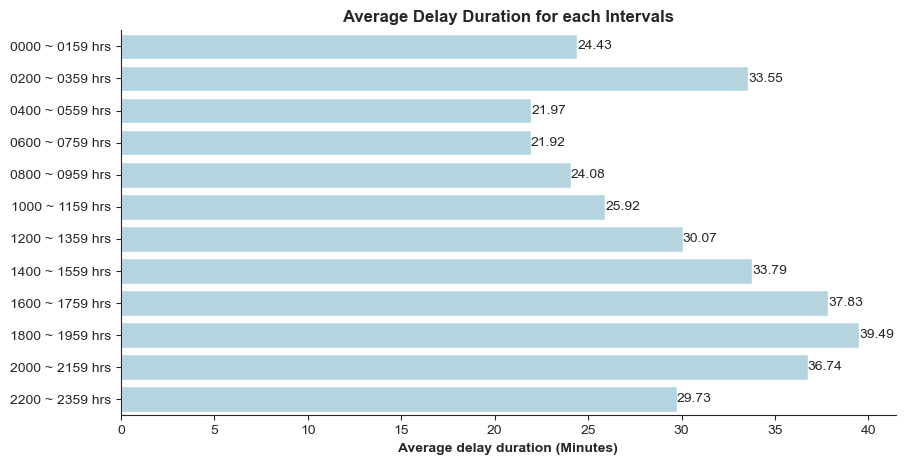

In [7]:
#Percentage of delayed flights for each interval
dailypercent = flight.groupby('DepInterval').ADelay.mean().reset_index()
dailypercent['Percent'] = (dailypercent['ADelay'] * 100).round(2)
dailypercent.drop(['ADelay'], axis= 1, inplace= True)
display(dailypercent)

fig, ax = plt.subplots(figsize = (12,5))
ax = sns.barplot(x= 'DepInterval', y = 'Percent', data=dailypercent, color='steelblue')
ax.bar_label(ax.containers[0])
plt.xlabel("")
plt.ylabel("Percentage (%)", fontweight='bold')
plt.xticks(rotation= 45, ha= 'right')
plt.title("Percentage of flights delayed for each interval", fontweight='bold')
plt.show()

#Average delay duration per interval
avg_delay = arrival_delay.groupby('DepInterval').ArrDelay.mean().reset_index()
avg_delay['ArrDelay'] = avg_delay['ArrDelay'].round(2)
display(avg_delay)

fig, ax = plt.subplots(figsize = (10,5))
ax = sns.barplot(y= 'DepInterval', x = 'ArrDelay', data=avg_delay, orient= 'h', color= 'lightblue')
sns.despine()
ax.bar_label(ax.containers[0])
plt.title("Average Delay Duration for each Intervals", fontweight='bold')
plt.xlabel("Average delay duration (Minutes)", fontweight='bold')
plt.ylabel('');

## Best day of the week

,DayOfWeek,Percentage
0,1,46.8
1,2,43.29
2,3,45.69
3,4,50.12
4,5,51.66
5,6,41.27
6,7,46.36


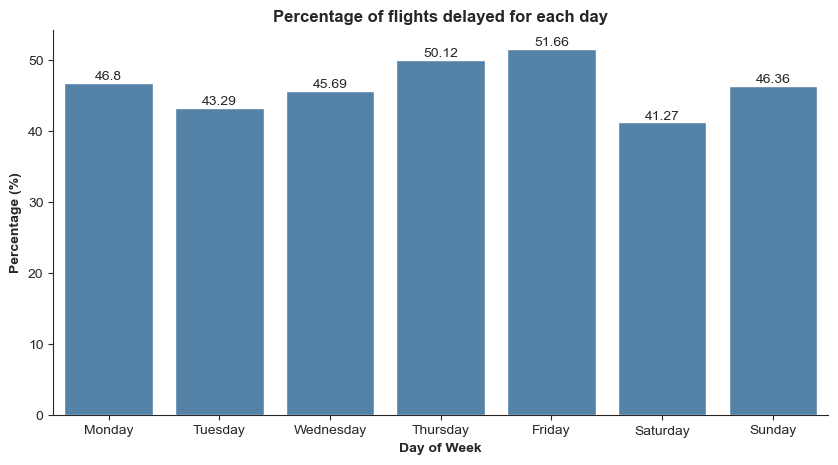

,DayOfWeek,ArrDelay
0,1,31.61
1,2,29.58
2,3,31.02
3,4,33.46
4,5,33.2
5,6,28.18
6,7,31.46


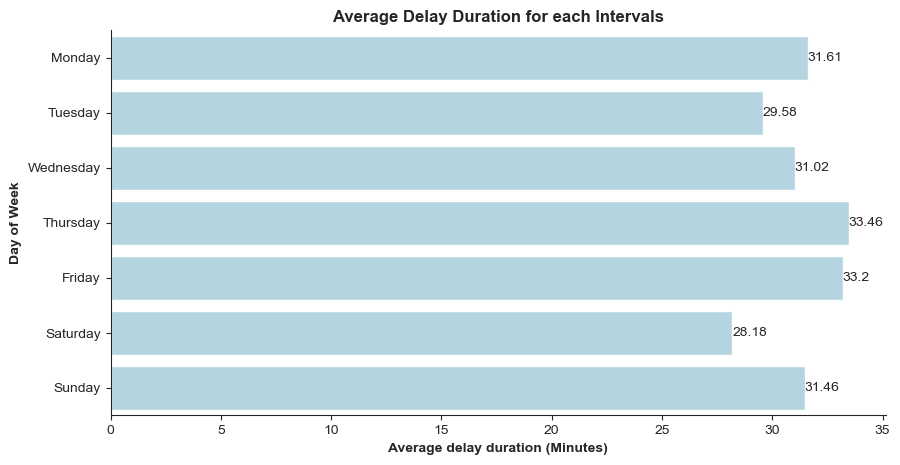

In [8]:
#Percentage of delayed flights for each interval
wpercent = flight.groupby('DayOfWeek').ADelay.mean().reset_index()
wpercent['Percentage'] = (wpercent['ADelay'] * 100).round(2)
wpercent.drop(['ADelay'], axis= 1, inplace= True)
display(wpercent)

fig, ax = plt.subplots(figsize = (10,5))
ax = sns.barplot(x= 'DayOfWeek', y = 'Percentage', data=wpercent, color= 'steelblue')
sns.despine()
ax.bar_label(ax.containers[0])
plt.xlabel("Day of Week", fontweight='bold')
plt.ylabel("Percentage (%)", fontweight='bold')
positions = (0, 1, 2, 3, 4, 5, 6)
labels = ("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday")
plt.xticks(positions, labels)
plt.title("Percentage of flights delayed for each day", fontweight='bold')
plt.show()

#Average delay duration per interval
avg_delay = arrival_delay.groupby('DayOfWeek').ArrDelay.mean().reset_index()
avg_delay['ArrDelay'] = avg_delay['ArrDelay'].round(2)
display(avg_delay)

fig, ax = plt.subplots(figsize = (10,5))
ax = sns.barplot(y= 'DayOfWeek', x = 'ArrDelay', data=avg_delay, orient= 'h', color= 'lightblue')
sns.despine()
ax.bar_label(ax.containers[0])
plt.title("Average Delay Duration for each Intervals", fontweight='bold')
plt.xlabel("Average delay duration (Minutes)", fontweight='bold')
plt.ylabel('Day of Week', fontweight='bold')
positions = (0, 1, 2, 3, 4, 5, 6)
labels = ("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday")
plt.yticks(positions, labels);

## Best time of year

,Month,Percentage
0,1,44.22
1,2,48.95
2,3,46.49
3,4,44.33
4,5,43.71
5,6,51.35
6,7,49.65
7,8,47.32
8,9,41.2
9,10,46.38


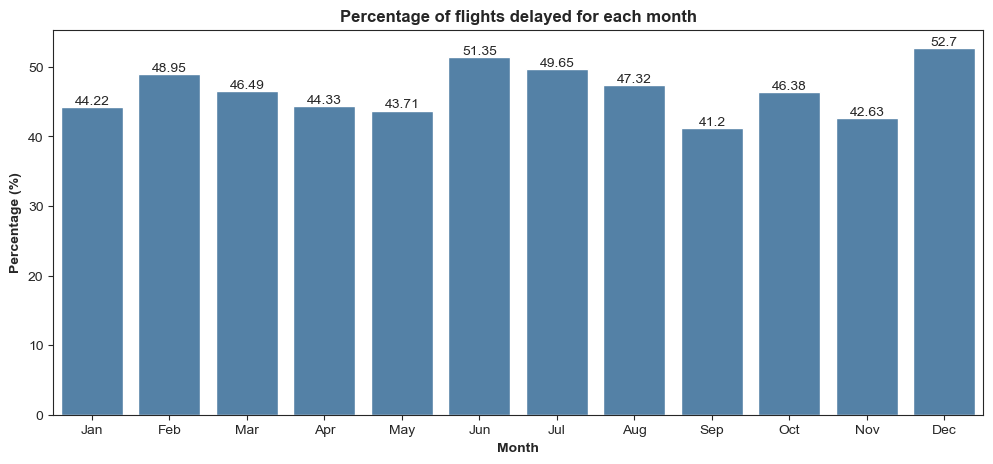

,Month,ArrDelay
0,1,29.59
1,2,31.67
2,3,30.71
3,4,28.91
4,5,28.21
5,6,35.94
6,7,34.95
7,8,32.81
8,9,28.88
9,10,29.7


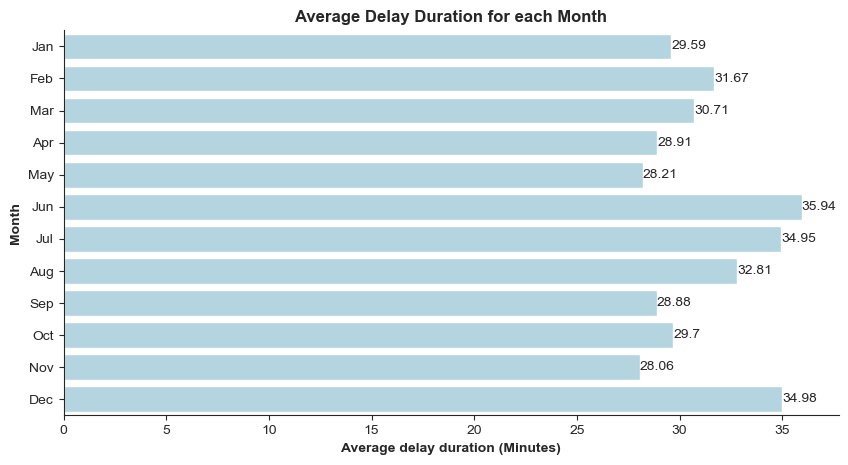

In [9]:
#Percentage of delayed flights for each month
mpercent = flight.groupby('Month').ADelay.mean().reset_index()
mpercent['Percentage'] = (mpercent['ADelay'] * 100).round(2)
mpercent.drop(['ADelay'], axis= 1, inplace= True)
display(mpercent)

fig, ax = plt.subplots(figsize = (12,5))
ax = sns.barplot(x= 'Month', y = 'Percentage', data=mpercent, color= 'steelblue')
ax.bar_label(ax.containers[0])
plt.xlabel("Month", fontweight='bold')
plt.ylabel("Percentage (%)", fontweight='bold')
positions = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)
labels = ("Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul","Aug", "Sep", "Oct", "Nov", "Dec")
plt.xticks(positions, labels)
plt.title("Percentage of flights delayed for each month", fontweight='bold')
plt.show()

#Average delay duration per interval
avg_delay = arrival_delay.groupby('Month').ArrDelay.mean().reset_index()
avg_delay['ArrDelay'] = avg_delay['ArrDelay'].round(2)
display(avg_delay)

fig, ax = plt.subplots(figsize = (10,5))
ax = sns.barplot(y= 'Month', x = 'ArrDelay', data=avg_delay, orient= 'h', color='lightblue')
sns.despine()
ax.bar_label(ax.containers[0])
plt.title("Average Delay Duration for each Month", fontweight='bold')
plt.xlabel("Average delay duration (Minutes)", fontweight='bold')
plt.ylabel('Month', fontweight='bold')
positions = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)
labels = ("Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul","Aug", "Sep", "Oct", "Nov", "Dec")
plt.yticks(positions, labels);

# Question 2: Do older planes suffer more delays?

In [10]:
plane_data = flight.merge(planes, left_on=('TailNum'), right_on=('tailnum'), how= 'left',).drop('tailnum', axis=1)
plane_data.rename(columns={'year':'ManYear'}, inplace=True)

#select the relevant columns
plane_data = plane_data[['Year', 'TailNum', 'ArrDelay', 'DepDelay', 'ADelay', 'DDelay', 'DepInterval', 'ManYear']]
display(plane_data)

,Year,TailNum,ArrDelay,DepDelay,ADelay,DDelay,DepInterval,ManYear
0,2006,N657AW,6,-2,True,False,0600 ~ 0759 hrs,1999
1,2006,N834AW,-5,0,False,False,1000 ~ 1159 hrs,None
2,2006,N605AW,-23,0,False,False,1800 ~ 1959 hrs,1997
3,2006,N312AW,-8,-2,False,False,1600 ~ 1759 hrs,NaN
4,2006,N309AW,0,-8,False,False,0800 ~ 0959 hrs,1990
...,...,...,...,...,...,...,...,...
14279052,2007,N670DN,13,-7,True,False,1600 ~ 1759 hrs,1992
14279053,2007,N829MH,5,11,True,True,1800 ~ 1959 hrs,2000
14279054,2007,N623DL,15,-1,True,False,1000 ~ 1159 hrs,1987
14279055,2007,N970DL,36,38,True,True,1200 ~ 1359 hrs,1990


In [11]:
#Change the data type of 'ManYear' to numeric
plane_data['ManYear'] = pd.to_numeric(plane_data['ManYear'], errors = 'coerce')
plane_data.dropna(subset=['ManYear'],inplace=True)

plane_data = plane_data.query("ManYear != 0")

plane_data = plane_data.astype({"Year": 'int16', "ManYear" : 'int16'})

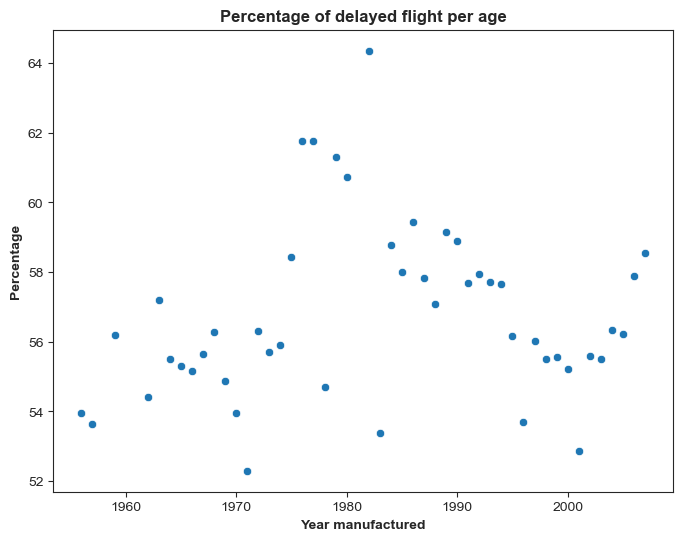

In [12]:
#percentage of flight delay
planepercent = plane_data.groupby('ManYear').apply(lambda x: ((x['ADelay']==1) | (x['DDelay']==1)).mean() * 100).reset_index(name='Percent')

fig, ax = plt.subplots(figsize = (8,6))
sns.scatterplot(x= 'ManYear', y = 'Percent', data=planepercent)
plt.title("Percentage of delayed flight per age", fontweight='bold')
plt.xlabel("Year manufactured", fontweight='bold')
plt.ylabel("Percentage", fontweight='bold');

# Question 3: How does the number of people flying between different locations change over time?

## Join the airport table with the flight table and rename the columns

In [75]:
info = flight.merge(airports, left_on=('Origin'), right_on='iata', how= 'left').drop('iata',axis=1).copy()
info.rename(columns={'state' :'OrigState', 'airport':'OrigAirport'},inplace=True)

info = info.merge(airports, left_on=('Dest'), right_on=('iata'), how = 'left').drop('iata',axis=1)
info.rename(columns={'state' :'DestState', 'airport':'DestAirport'},inplace= True)

info = info[["Year", "Origin", "Dest", "OrigState", "DestState"]]
info = info.astype({'Year': 'int32', 'OrigState':'category', 'DestState':'category'})
info.dtypes

Year            int32
Origin         object
Dest           object
OrigState    category
DestState    category
dtype: object

## Calculate the total number of inbound and outbound flights and the difference

In [93]:
#outbound flights
outvalues = info.groupby(['OrigState', 'Year']).size().reset_index(name='Total')
outbound = outvalues.pivot(index='OrigState', columns='Year', values='Total').reset_index()

#find the difference
outbound['Diff'] = outbound[2007] - outbound[2006]
outbound = outbound.rename(columns={'OrigState': 'State'})

# Remove any rows with missing values and sort the data by the difference
outbound = outbound.dropna().sort_values(by='Diff', ascending=False).reset_index(drop=True)

#inbound flights
inbound = info.groupby(['DestState', 'Year']).size().reset_index(name='Total')
inbound = inbound.pivot(index='DestState', columns='Year', values='Total')
inbound.rename(columns={'Year':'Index'}, inplace=True)

#find the difference
inbound['Diff'] = inbound[2007] - inbound[2006]
inbound = inbound.reset_index().rename(columns={'DestState': 'State'})

# Remove any rows with missing values and sort the data by the difference
inbound = inbound.dropna().sort_values(by='Diff', ascending=False)

In [91]:
#States with the highest increase in outbound flights
display(outbound.head(5))

#States with the highest decrease in outbound flights
display(outbound.tail(5))

Year,State,2006,2007,Diff
0,MI,164864,213914,49050
1,TN,121641,162213,40572
2,MN,128397,158329,29932
3,CA,847095,876506,29411
4,FL,449104,471906,22802


Year,State,2006,2007,Diff
47,NJ,154182,149307,-4875
48,OH,146153,140584,-5569
49,VA,236831,223979,-12852
50,KY,152598,139298,-13300
51,TX,796975,773055,-23920


In [92]:
#States with the highest increase in outbound flights
display(inbound.head(5))

#States with the highest decrease in outbound flights
display(inbound.tail(5))

Year,State,2006,2007,Diff
21,MI,165013,213611,48598
42,TN,121972,162185,40213
4,CA,847426,877615,30189
22,MN,128307,157951,29644
8,FL,450325,472841,22516


Year,State,2006,2007,Diff
30,NJ,153643,148832,-4811
34,OH,146512,140913,-5599
45,VA,236853,224171,-12682
16,KY,152213,139000,-13213
43,TX,795551,770647,-24904


## Changes in number of flights between 2006 and 2007

### Top 5 increase in Outbound and Inbound flights

,State,Direction,Value
0,MI,Outbound,49050
1,TN,Outbound,40572
2,MN,Outbound,29932
3,CA,Outbound,29411
4,FL,Outbound,22802
5,MI,Inbound,48598
6,TN,Inbound,40213
7,MN,Inbound,29644
8,CA,Inbound,30189
9,FL,Inbound,22516


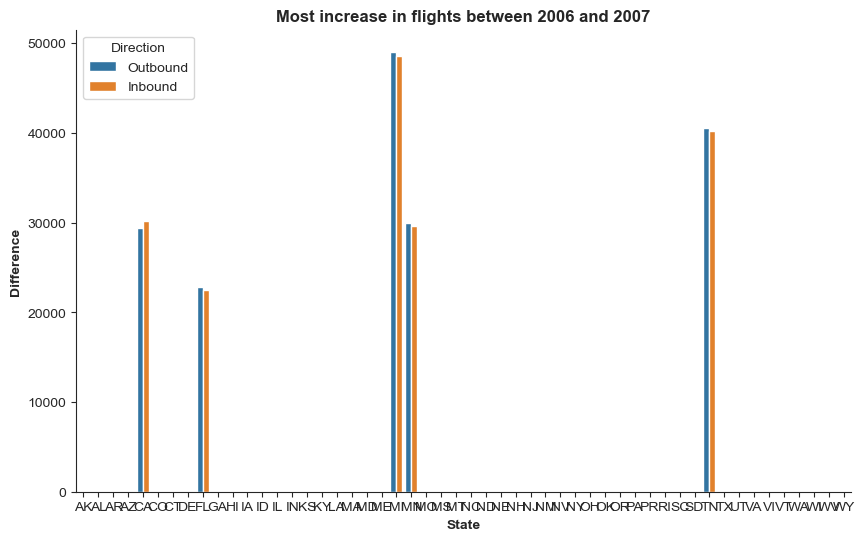

In [141]:
#most and least changes to outbound flight 
mostout = outbound.head(5).copy()
mostout.rename(columns={'Diff':'Outbound'}, inplace= True)
mostin = inbound.head(5).copy()
mostin.rename(columns={'Diff':'Inbound'}, inplace= True)
increase= mostout.merge(mostin, left_on='State', right_on='State', how= 'left').drop(['2006_x', '2007_x', '2006_y', '2007_y'],axis=1).reset_index(drop=True)

# reshape the data frame to a long format
increase_long = pd.melt(increase, id_vars='State', value_vars=['Outbound', 'Inbound'], var_name='Direction', value_name='Value').reset_index(drop=True)
increase_long.dropna(inplace=True)
display(increase_long)

# create the grouped bar plot using seaborn
fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(data=increase_long, x='State', y='Value', hue='Direction')
sns.despine()
plt.xlabel('State', fontweight = 'bold')
plt.ylabel("Difference", fontweight = 'bold')
plt.title("Most increase in flights between 2006 and 2007", fontweight = 'bold');

### Top 5 decrease in Outbound and Inbound flights

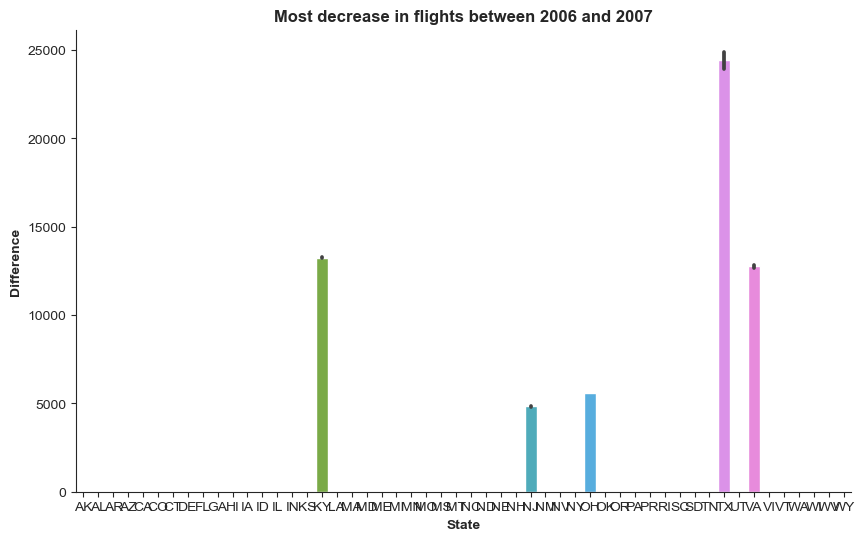

In [147]:
leastout = outbound.tail(5)
leastin = inbound.tail(5)
least = pd.concat([leastout, leastin])
least['Diff'] = abs(least['Diff'])

fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(x='State', y= 'Diff', data=least)
sns.despine()
plt.xlabel('State', fontweight = 'bold')
plt.ylabel("Difference", fontweight = 'bold')
plt.title("Most decrease in flights between 2006 and 2007", fontweight = 'bold');

# Question 4: Can you detect cascading failures as delays in one airport create delays in others?

# Question 5: Use the available variables to construct a model that predicts delays.

In [ ]:
flight['Delayed'] = ((flight.ADelay == True) | (flight.DDelay == True)).astype(int)
skim(flight)

## Convert the relevant columns to the specific data types.

In [ ]:
flight[['Year', 'Month', 'DayofMonth']] = flight[['Year', 'Month', 'DayofMonth']].astype('int')
flight[['DayOfWeek', 'DepInterval','Origin','Dest']] = flight[['DayOfWeek', 'DepInterval','Origin','Dest']].astype('category')

## Take 100,000 samples from flights table to construct models that predict delays

In [ ]:
delay_model = flight.sample(n=10**4, random_state=1)
delay_model.shape

## Pipelines: Pre-Processing

In [ ]:
features = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepInterval','Origin','Dest']
X = delay_model[features].copy()
y = delay_model['Delayed']

In [ ]:
numerical_features = ['Year', 'Month', 'DayofMonth']

# Applying SimpleImputer and StandardScaler into a pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())])


categorical_features = ['DayOfWeek', 'DepInterval','Origin','Dest']

# Applying SimpleImputer and then OneHotEncoder into another pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('onehot', OneHotEncoder(drop=None, handle_unknown='ignore'))])

data_transformer = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_features),
        ('categorical', categorical_transformer, categorical_features)])

## Create the test and training sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=1)

## Set the parameters

In [ ]:
param_grid = {
    'data_transformer__numerical__imputer__strategy': ['mean', 'median'],
    'data_transformer__categorical__imputer__strategy': ['constant','most_frequent']
}

## Logistic Regression

In [ ]:
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                      ('pipe_lr', LogisticRegression(max_iter=10000, penalty = None))])
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid)
grid_lr.fit(X_train, y_train);

## Gradient Boosting

In [ ]:
pipe_gdb = Pipeline(steps=[('data_transformer', data_transformer),
       ('pipe_gdb',GradientBoostingClassifier(random_state=2))])

grid_gdb = GridSearchCV(pipe_gdb, param_grid=param_grid)
grid_gdb.fit(X_train, y_train);

## Penalised logistic regression

In [ ]:
pipe_plr = Pipeline(steps=[('data_transformer', data_transformer),
                           ('pipe_plr', LogisticRegression(penalty='l1', max_iter=10000, tol=0.01, solver='saga'))])
grid_plr = GridSearchCV(pipe_plr, param_grid=param_grid)
grid_plr.fit(X_train, y_train);

## Classification tree

In [ ]:
pipe_tree = Pipeline(steps=[('data_transformer', data_transformer),
                           ('pipe_tree', DecisionTreeClassifier(random_state=0))])
grid_tree = GridSearchCV(pipe_tree, param_grid=param_grid)
grid_tree.fit(X_train, y_train);

## Random forests

In [ ]:
pipe_rf = Pipeline(steps=[('data_transformer', data_transformer),
                           ('pipe_rf', RandomForestClassifier(random_state=0))])
grid_rf = GridSearchCV(pipe_rf, param_grid=param_grid)
grid_rf.fit(X_train, y_train);

## Support vector machines

In [ ]:
pipe_svm = Pipeline(steps=[('data_transformer', data_transformer),
                           ('pipe_svm',  LinearSVC(random_state=0, max_iter=10000, tol=0.01))])
grid_svm = GridSearchCV(pipe_svm, param_grid=param_grid)
grid_svm.fit(X_train, y_train);

## Compare the performance of the classification models by the ROC curve

In [ ]:
# create the ROC curve display objects for each classifier
roc_display_lr = RocCurveDisplay.from_estimator(grid_lr, X_test, y_test, name='Logistic Regression');
roc_display_gdb = RocCurveDisplay.from_estimator(grid_gdb, X_test, y_test, name='Gradient Boosting');
roc_display_plr = RocCurveDisplay.from_estimator(grid_plr, X_test, y_test, name='Penalised logistic regression');
roc_display_tree = RocCurveDisplay.from_estimator(grid_tree, X_test, y_test, name='Classification trees');
roc_display_rf = RocCurveDisplay.from_estimator(grid_rf, X_test, y_test, name='Random forests');
roc_display_svm = RocCurveDisplay.from_estimator(grid_svm, X_test, y_test, name='Support vector machines');

# create a new figure and plot the ROC curves on the same axes
fig, ax = plt.subplots(figsize=(8, 6))
roc_display_lr.plot(ax=ax);
roc_display_gdb.plot(ax=ax);
roc_display_plr.plot(ax=ax);
roc_display_tree.plot(ax=ax);
roc_display_rf.plot(ax=ax);
roc_display_svm.plot(ax=ax);

# add the 50-50 line (i.e., diagonal line) to the plot as a reference for a random classifier
ax.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')

# set the x and y limits to be between 0 and 1
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])

# set the plot title and axis labels
ax.set_title('ROC curves for different classifiers', fontweight='bold')
ax.set_xlabel('False Positive Rate', fontweight='bold')
ax.set_ylabel('True Positive Rate', fontweight='bold')

# show the plot
plt.show()